<div style="text-align: center;">
  <h1>TA136 - Taller de Procesamiento de Señales</h1>
  <h2>Trabajo Práctico 5: Máquina de Vectores Soporte</h2>
</div>

---
---

<div style="text-align: center;">
  <h3> Introducción
</div>

En este trabajo práctico se estudió el problema de clasificación de erupciones de géiseres usando *Support Vector Machines*. El objetivo es distinguir entre erupciones cortas y largas, basándose en dos características: la duración de la erupción y el tiempo de espera hasta la siguiente. Para eso, se plantearon dos problemas de optimización: el primal y el dual. También, se relajaron los márgenes a modo de analizar los resultados obtenidos y compararlos con los anteriores. Todo esto se hizo para encontrar el hiperplano que mejor separa ambas clases.

El desarrollo se realiza a partir de la carga del dataset `geyser` de la librería `seaborn`, donde se asignaron etiquetas numéricas a las clases para poder tratarlas matemáticamente. Luego, se formularon matemáticamente los problemas a tratar y se implementaron dos clases distintas: `svm_primal` y `svm_dual`, que obtienen los parámetros $w$, $b$ y $\xi$ (en caso de márgenes relajados) de cada método utilizando la función $\texttt{solve\_qp}$ de la librería `qpsolvers`.

Finalmente, se graficaron los datos, el hiperplano, los márgenes y las rectas de vectores soporte para visualizar el desempeño de cada modelo de forma clara y poder compararlos entre sí. Toda esta implementación se hizo en $\texttt{Python}$, utilizando `Numpy`, `Matplotlib` y las librerías mencionadas con antelación.


---
---

<div style="text-align: center;">
  <h3> Desarrollo
</div>

Un géiser es un tipo especial de fuente hidrotermal que emite esporádicamente una columna de agua caliente y vapor al aire. Se desea clasificar el tipo de erupción de Yellowstone National Park (EEUU) a partir del tiempo de espera hasta la erupción y la duración de la misma.

---

**(A). Cargar la base de datos utilizando $\texttt{load\_dataset(’geyser’)}$ (`seaborn`).**

&ensp; En un principio, se carga el conjunto de datos `geyser` utilizando la función recomendada por la cátedra. Además, se agrega una columna `clase` con los valores numéricos de las clases ($-1$ o $1$) según si se trata de un geyser corto o largo, respectivamente. Una vez realizado esto, se imprime el dataset para verificar que los datos se hayan cargado correctamente.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import qpsolvers as qp


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
dataset = sns.load_dataset('geyser')
dataset['class'] = dataset['kind'].map({'short': -1.0, 'long': 1.0})
display(dataset)

,duration,waiting,kind,class
0,3.600,79,long,1.0
1,1.800,54,short,-1.0
2,3.333,74,long,1.0
3,2.283,62,short,-1.0
4,4.533,85,long,1.0
...,...,...,...,...
267,4.117,81,long,1.0
268,2.150,46,short,-1.0
269,4.417,90,long,1.0
270,1.817,46,short,-1.0


&ensp; En base al conjunto de datos creado anteriormente, se separan dos *dataframes* distintos según la clase que tengan y se verifica que la dimensión total sea de $272 \times 4$, ya que, es el total de datos específicados por la librería `seaborn`.

In [3]:
data_short = dataset[dataset['class'] == -1.0]
data_long = dataset[dataset['class'] == 1.0]
display(data_short.shape, data_long.shape)

(100, 4)

(172, 4)

&ensp; Se define una función auxiliar que permite graficar un *scatter plot* de las clases del geyser en función de la duración de la erupción y el tiempo de espera de la misma. La función recibe como entrada un *dataframe* por clase, junto con un título y una paleta de colores. Esto permite reutilizar el mismo código para generar múltiples gráficos a lo largo del trabajo, mejorando la legibilidad y evitando repeticiones.


In [4]:
def scatter_dataset(datos_0, datos_1, title, colors):
    plt.scatter(datos_0['duration'], datos_0['waiting'], marker = 'x', c = colors[0], label = 'Short', zorder = 2)
    plt.scatter(datos_1['duration'], datos_1['waiting'], marker = '+', c = colors[1], label = 'Long', zorder = 2)
    plt.xlabel('Duration')
    plt.ylabel('Waiting')
    plt.title(title)
    plt.xlim(1.5, 5.2)
    plt.ylim(40, 100)

&ensp; De esta manera, se definen los colores a utilizar y se realiza el *scatter plot*, mostrando los datos del dataset según su clase, en función de la duración y el tiempo de espera de las erupciones.

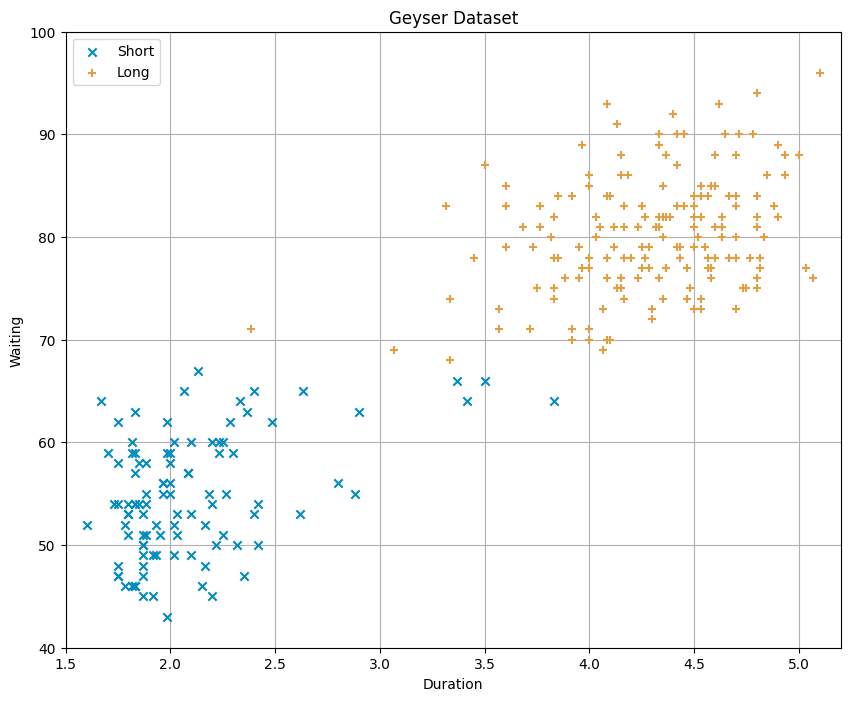

In [5]:
colors = ['#038bbb', '#e19f41']

plt.figure(figsize = (10, 8))
scatter_dataset(data_short, data_long, 'Geyser Dataset', colors)
plt.grid(zorder = 1)
plt.legend(loc = 'upper left')
plt.show()

---

**(B). Implementar una clasificación SVM utilizando $\texttt{solve\_qp}$ (`qpsolvers`), resolviendo el problema primal. El código debe estar estructurado de la siguiente manera:**

```python
    class SVM:
        # Inicializar atributos y declarar hiperparámetros
        def __init__(self,...

        # Etapa de entrenamiento
        def fit(self, X, y):

        # Etapa de testeo
        def predict(self, X):
```

**Graficar la frontera de decisión y las rectas de vectores soportes sobre un $\texttt{scatter}$.**

&ensp; En un principio, a partir del *dataframe* cargado previamente, se define la matriz $X$ con las duraciones y el tiempo de espera de las erupciones y el vector $y$ con las clases.

In [6]:
X_data = np.array(dataset[['duration', 'waiting']])
Y_data = np.array(dataset['class']).reshape(-1, 1)

display(X_data.shape)
display(Y_data.shape)

(272, 2)

(272, 1)

&ensp; Antes de describir lo realizado, se realiza un paneo teórico de lo desarrollado. Para esto, se debe tener en cuenta que el problema primal del *SVM* busca maximizar los márgenes, es decir, la distancia entre las muestras más cercanas de cada lado del hiperplano.

&ensp; Para lograr esto, se comienza entendiendo que $w$ es ortogonal a la frontera de decisión, pues es la normal de la misma. Esto se debe a que la frontera está definida de la siguiente forma:

$$w^T \cdot x + b = 0.$$

Definiendo un punto $x^*$ como la proyección ortogonal de otro punto $x_i$ cualquiera del plano sobre la frontera de decisión, se puede operar tal que:

$$w^T \cdot x_i + b = w^T \cdot x_i + b - \underbrace{\left( w^T \cdot x^* + b \right)}_{= ~ 0 ~~ (\in ~ \text{frontera})} = w^T \cdot \left( x_i - x^* \right) \iff |w^T \cdot x_i + b| = ||w|| \cdot || x_i - x^* ||.$$

&ensp; En base a esto, se puede encontrar la distancia de un punto al hiperplano de separación.

$$d(x_i) = || x_i - x^* || = \frac{|w^T \cdot x_i + b|}{||w||} \xrightarrow[]{|w^T x_i + b|| ~ = ~ y_i (w^T x_i + b)} d(x_i) = \frac{y_i \cdot (w^T x_i + b)}{||w||};$$

más precisamente, si se interesa analizar la distancia al vector soporte, $y_i \cdot \left( w^T X_i + b \right) = 1$:

$$d(x_i) = \frac{1}{||w||}.$$

&ensp; Recordando que se busca maximizar el margen, esta expresión es la que se debe maximizar, lo que equivale a minimizar su inversa:

$$\max_{w, ~ b} \frac{1}{||w||} ≡ \min_{w, ~ b} ||w||.$$

&ensp; Entonces, se plantea minimizar el cuadrado de la norma en lugar de la norma directamente, ya que, permite evitar las raíces cuadradas, lo cual simplifica el análisis matemático y resulta computacionalmente más eficiente. Por lo tanto, se obtiene la siguiente expresión, que es la formulación del problema primal.

$$\min_{w, ~ b} \frac{1}{2} ||w||^2 ~~~~~~~ \text{s.t.} ~~~~~~~ y_i \left( w^T x_i + b \right) \geq 1, ~~ \forall 1 \leq i \leq n.$$

&ensp; Donde la restricción $y_i \left( w^T x_i + b \right) \geq 1$ garantiza que todos los puntos estén correctamente clasificados y a una distancia mínima del hiperplano. Esto asegura que no solo estén del lado correcto de la frontera de decisión, sino también fuera de la "zona de margen", respetando el ancho máximo posible entre las clases.

&ensp; De esta manera, el objetivo es reformular el problema primal en una expresión del tipo:

$$\min_{z} \frac{1}{2} z^t P z + q^t z ~~~~~~~ \text{s.t.} ~~~~~~~ Gz \leq h, ~~~ Az = b, ~~~ lb \leq z \leq ub;$$

puesto que la función $\texttt{solve\_qp}$ recibe parámetros que se correspondan con esta forma. Entonces, se considera:

$$z = \begin{bmatrix} w_1 \\ w_2 \\ b \end{bmatrix} \in \mathbb{R}^{3 \times 1}, ~
P = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{bmatrix} \in \mathbb{R}^{3 \times 3}, ~
q = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix} \in \mathbb{R}^{3 \times 1}.$$

&ensp; Así, se tiene que:

\begin{align*}
  \min_{z} \frac{1}{2} z^t P z + q^t z &= \min_{w, ~ b} \frac{1}{2} \begin{bmatrix} w_1 & w_2 & b \end{bmatrix}
  \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{bmatrix}
  \begin{bmatrix} w_1 \\ w_2 \\ b \end{bmatrix} + \begin{bmatrix} 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} w_1 \\ w_2 \\ b \end{bmatrix} \\
  &= \min_{w, ~ b} \frac{1}{2} \left( w_1^2 + w_2^2 \right) \\
  &= \min_{w, ~ b} \frac{1}{2} ||w||^2.
\end{align*}

&ensp; Por otro lado, se definen las matrices de restricciones del problema primal de la siguiente manera:

$$G = -\begin{bmatrix} y_1 X_{1, 1} & y_1 X_{1, 2} & y_1 \\ y_2 X_{2, 1} & y_2 X_{2, 2} & y_2 \\ \vdots & \vdots & \vdots \\
y_n X_{n, 1} & y_n X_{n, 2} & y_n \end{bmatrix} \in \mathbb{R}^{n \times 3}, ~
h = - \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} \in \mathbb{R}^{n \times 1};$$

que verifican:

\begin{align*}
  Gz \leq h &\iff -\begin{bmatrix} y_1 X_{1, 1} & y_1 X_{1, 2} & y_1 \\ y_2 X_{2, 1} & y_2 X_{2, 2} & y_2 \\ \vdots & \vdots & \vdots \\
  y_n X_{n, 1} & y_n X_{n, 2} & y_n \end{bmatrix} \begin{bmatrix} w_1 \\ w_2 \\ b \end{bmatrix} \leq - \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} \iff \begin{bmatrix} -y_1 X_{1, 1} \cdot w_1 - y_2 X_{1, 2} \cdot w_2 - y_1 \cdot b \\ -y_1 X_{2, 1} \cdot w_1 - y_2 X_{2, 2} \cdot w_2 - y_2 \cdot b \\
  \vdots \\ -y_n X_{n, 1} \cdot w_1 - y_n X_{n, 2} \cdot w_2 - y_n \cdot b \end{bmatrix} \leq - \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} \\ \\
  &\iff -y_i \cdot \left( w^T X_i + b \right) \leq -1, ~~ \forall 1 \leq i \leq n \iff y_i \cdot \left( w^T X_i + b \right) \geq 1, ~~ \forall 1 \leq i \leq n
\end{align*}

&ensp; Volviendo al código, basado en esta formulación primal, se implementa una clase denominada `svm_primal`. Cabe destacar que la clase también contempla el caso de bordes suavizados (cuando `C != None`), debido a la similitud en la estructura del algoritmo. A continuación, se describen sus principales métodos:

- `__init__:` Inicializa la clase y define los atributos para almacenar los parámetros del modelo, tales como los coeficientes $w$, el término $b$, las variables $\xi$ y $c$ en el caso en el que se deseen suavizar los bordes `C != None`, como se verá más adelante.

- `fit:` Ajusta el modelo a los datos de entrenamiento siguiendo los pasos:
    1. Construcción de los vectores y matrices `P`, `q`, `G` y `h` asociados al problema primal.

    2. Resolución del problema de optimización utilizando la función $\texttt{solve\_qp}$ a partir de los vectores y matrices del punto anterior.

    3. A partir de la solución, se obtienen $w$ y $b$.

- `predict:` Realiza predicciones para nuevos datos una vez que el modelo ha sido entrenado. Utiliza los coeficientes obtenidos en la fase de entrenamiento para estimar las clases correspondientes a los datos de entrada, según la ecuación: $$ \hat{y} = w^T \cdot X + b .$$ Devuelve $-1$ o $1$, es decir, el signo resultante, con el fin de predecir la clase.

&ensp; Cabe destacar que si se quisiera extender el modelo para trabajar con *SVM* no lineales, sería posible adaptar el procedimiento utilizando un *kernel*, más adelante se aborda el tema de una mejor forma.



In [7]:
class svm_primal:
    # Inicializar atributos y declarar hiperparámetros
    def __init__(self, C = None):
        self.c = C
        self.w = None
        self.b = None
        self.xi = None

    # Etapa de entrenamiento
    def fit(self, X, y):
        n_fit, n_caracteristicas = X.shape
        n__bordes = 0
        if self.c != None:
            n__bordes = n_fit

        P = np.zeros((n_caracteristicas + 1 + n__bordes, n_caracteristicas + 1 + n__bordes))
        P[:n_caracteristicas, :n_caracteristicas] = np.eye(n_caracteristicas)
        G = -np.c_[y * X, y]
        h = -np.ones(n_fit)
        q = np.zeros(n_caracteristicas + 1)
        if self.c != None:
            G1 = np.c_[G, -np.eye(n_fit)]
            G2 = np.c_[np.zeros((n_fit, n_caracteristicas + 1)), np.eye(n_fit)]
            G = np.r_[G1, -G2]
            h = np.r_[h, -np.zeros(n_fit)]
            q = np.r_[q, np.ones(n_fit) * self.c]

        z = qp.solve_qp(P = P, q = q, G = G, h = h, solver = 'cvxopt')

        self.w = z[:n_caracteristicas]
        self.b = z[n_caracteristicas]
        if self.c != None:
            self.xi = z[n_caracteristicas + 1:n_caracteristicas + 1 + n__bordes]

    # Etapa de testeo
    def predict(self, X):
        return np.sign(X @ self.w + self.b)

&ensp; En primer lugar, se inicializa y se entrena el modelo con la totalidad de las muestras del dataset. Se decide no separarlas en muestras de entrenamiento y de testeo, ya que, al ser pocas muestras ($272$), se utilizan todas para entrenar el modelo.

In [8]:
SVM_Primal = svm_primal()
SVM_Primal.fit(X_data, Y_data)

&ensp; Con el objetivo de graficar cada una de las fronteras de decisión y las rectas de los vectores soporte de los distintos métodos, se abstrae la siguiente lógica encapsulada dentro de la función $\texttt{plot\_boundaries}$.

&ensp; Para ello, se usa el método `predict` sobre todos los puntos de la grilla para estimar a qué clase pertenecería cada uno. Estas predicciones se representan con $\texttt{plt.contourf}$, generando las dos regiones correspondientes a las clases. Asimismo, se grafican las rectas de vectores soporte, que siguen la siguiente expresión.

$$y_i \cdot \left( w^T X_i + b \right) = 1 \Longrightarrow \begin{bmatrix} w_1 & w_2 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \end{bmatrix} + b = \pm 1$$

La frontera de decisión sigue la misma lógica, pero igualada a cero.

In [9]:
def plot_boundaries(model, colors):
    x = np.linspace(1, 5.5, 1000)
    y = np.linspace(40, 100, 1000)
    XX, YY = np.meshgrid(x, y)
    grid = np.column_stack((XX.ravel(), YY.ravel()))

    Z = model.predict(grid).reshape(XX.shape)

    plt.contourf(XX, YY, Z, levels = [-1, 0, 1], colors = colors, alpha = 0.4, linestyles = 'solid')

    plt.plot(x, (-model.w[0] * x - model.b) / model.w[1], color = 'black', label = 'Frontera de Decisión')
    plt.plot(x, (-model.w[0] * x - model.b + 1) / model.w[1], color = 'black', ls = '--', label = 'Rectas de Vectores Soporte')
    plt.plot(x, (-model.w[0] * x - model.b - 1) / model.w[1], color = 'black', ls = '--')

&ensp; De esta forma, se grafica el dataset de muestras, la frontera de decisión y las rectas de vectores soporte a partir de las funciones implementadas: $\texttt{scatter\_dataset}$ y $\texttt{plot\_boundaries}$.

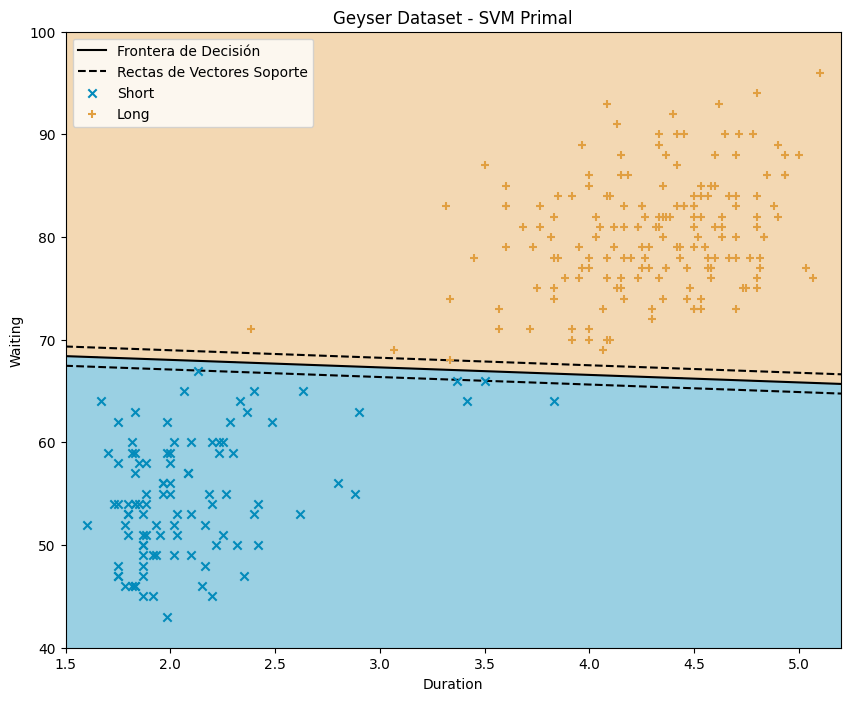

In [10]:
plt.figure(figsize = (10, 8))
plot_boundaries(SVM_Primal, colors)
scatter_dataset(data_short, data_long, 'Geyser Dataset - SVM Primal', colors)
plt.legend(loc = 'upper left')
plt.show()

---

**(C). Repetir el inciso (B) resolviendo el problema dual.**

&ensp; Previamente a presentar la implementación realizada, se realiza un breve repaso teórico del enfoque seguido. Para ello, se reescribe el problema primal (visto en el ejercicio **(B)**) en función de sus multiplicadores de Lagrange ($\alpha_i$):

$$\min_{w, ~ b} \max_{\alpha_i} \frac{1}{2} ||w||^2 - \sum_{i = 1}^n \alpha_i \cdot \left[ y_i (w^T x_i + b) - 1\right].$$

&ensp; Invirtiendo el máximo y el mínimo, se tiene el problema dual:

$$\max_{\alpha_i} \min_{w, ~ b}  \frac{1}{2} ||w||^2 - \sum_{i = 1}^n \alpha_i \cdot \left[ y_i (w^T x_i + b) - 1\right];$$

que, en general, por Teorema de *Weak and Strong Duality* es menor a la expresión anterior puesto que el mínimo del máximo es mayor o igual al máximo del mínimo. Sin embargo, al ser el problema de *SVM* convexo, son iguales.

&ensp; Entonces, se define $f(w, ~ b, ~ \alpha)$ como la función a optimizar:

\begin{align*}
f(w, ~ b, ~ \alpha) &= \frac{1}{2} ||w||^2 - \sum_{i = 1}^n \alpha_i \cdot \left[ y_i (w^T x_i + b) - 1\right] \\
&=  \frac{1}{2} ||w||^2 - w^T \sum_{i = 1}^n \alpha_i y_i x_i - b \sum_{i = 1}^n \alpha_i y_i + \sum_{i=1}^n \alpha_i.
\end{align*}

Derivando esto en función de $w$ y $b$ e igualando a cero, se puede reescribir $f(w, ~ b, ~ \alpha)$, tal que:

\begin{align*}
\begin{cases}
\frac{\partial}{\partial w} f(w, ~ b, ~ \alpha) = w - \sum_{i = 1}^n \alpha_i y_i x_i = 0 \Rightarrow w = \sum_{i = 1}^n \alpha_i y_i x_i \\
\frac{\partial}{\partial b} f(w, ~ b, ~ \alpha) = -\sum_{i = 1}^n \alpha_i y_i = 0
\end{cases}
\end{align*}

\begin{align*}
\Longrightarrow f(w, ~ b, ~ \alpha) &= \frac{1}{2} ||w||^2 - w^T \underbrace{\sum_{i = 1}^n \alpha_i y_i x_i}_w - \underbrace{b \sum_{i = 1}^n \alpha_i y_i}_{=~0} + \sum_{i=1}^n \alpha_i \\
&= \frac{1}{2} ||w||^2 - ||w||^2 + \sum_{i=1}^n \alpha_i \\
&= -\frac{1}{2} ||w||^2 + \sum_{i=1}^n \alpha_i.
\end{align*}

Teniendo en cuenta que tanto la norma al cuadrado de $w$, como la sumatoria de los $\alpha_i$ se pueden reescribir como:
\begin{align*}
\sum_{i=1}^n \alpha_i &= \alpha^T 1 \\
||w||^2 &= \sum_{i = 1}^n \sum_{j = 1}^n \alpha_i \alpha_j ~ y_i y_j ~ x_i^T x_j = \alpha^T Q \alpha;
\end{align*}

siendo $Q = y_i y_j ~ x_i^T x_j$. Entonces, el problema dual del *SVM* se plantea como la maximización de la siguiente expresión:

$$\max_{w, ~ b} -\frac{1}{2} \alpha^T P \alpha + \alpha^T 1 ~~~~~~~ \text{s.t.} ~~~~~~~ \alpha^T y = 0, ~ \alpha_i \geq 0.$$

Donde la restricción $\alpha^T y = 0$ proviene de las derivadas parciales realizadas anteriormente y $\alpha_i \geq 0$ se debe a propiedades de los multiplicadores de Lagrange.

&ensp; Cabe destacar que a partir del desarrollo anterior se tiene una expresión para $w$, mientras que para $b$ surge de la expresión de los vectores soporte, tal que:

\begin{align*}
y_i \cdot \left( w^T X_i + b \right) = 1 \iff b &= y_i - w^T x_i \\
&= \frac{1}{N_S} \sum_{i=0}^{N_S} y_i - w^T X_i ~~ \forall i \in \text{VS};
\end{align*}

siendo N_S la cantidad de vectores soporte.

&ensp; De esta forma, volviendo al problema dual, se desea reformularlo en la forma estándar de un problema cuadrático para pasarlo a la función $\texttt{solve\_qp}$:

$$\min_{z} \frac{1}{2} z^T P z + q^T z ~~~~~~~ \text{s.t.} ~~~~~~~ Gz \leq h, ~~~ Az = b, ~~~ lb \leq z \leq ub.$$

Donde, se define:

$$z = \alpha = \begin{bmatrix} \alpha_1 \\ \alpha_2 \\ \vdots \\ \alpha_n \end{bmatrix} \in \mathbb{R}^{n \times 1}, ~
P = (y ~ y^T) \cdot (X ~ X^T) \in \mathbb{R}^{n \times n},  ~
q = -\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} \in \mathbb{R}^{n \times 1}.$$

De este modo, se tiene que:

\begin{align*}
  \min_{z} \frac{1}{2} z^t P z + q^t z &= \min_{w, ~ b} \frac{1}{2} \alpha^T P
  \alpha + q^T \alpha \\
  &= \min_{w, ~ b} \frac{1}{2} \alpha^T P \alpha + \alpha^T q \\
  &= \min_{w, ~ b} \frac{1}{2} \alpha^T P \alpha - \alpha^T 1. \\
\end{align*}

Esta expresión es equivalente al problema dual en forma de maximización, ya que minimizar una función es lo mismo que maximizar su negación:

\begin{align*}
  \min_{w, ~ b} \frac{1}{2} \alpha^T P \alpha - \alpha^T 1 &= - \max_{w, ~b} \frac{1}{2} \alpha^T P \alpha - \alpha^T 1 \\
  &= \max_{w, ~b} - \frac{1}{2} \alpha^T P \alpha + \alpha^T 1.
\end{align*}

&ensp; Para las restricciones del problema:

- La condición $\alpha_i \geq 0$ se obtiene a partir de: $$G = -I_n \in \mathbb{R}^{n \times n}, ~
h = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} \in \mathbb{R}^{n \times 1};$$ ya que:
\begin{align*}
  Gz \leq h &\iff -\begin{bmatrix} 1 & 0 & \dots & 0 \\ 0 & 1 & \dots & 0 \\ \vdots &  & \ddots & \vdots \\ 0 & 0 & \dots & 1 \end{bmatrix} \begin{bmatrix} \alpha_1 \\ \alpha_2 \\ \vdots \\ \alpha_n \end{bmatrix} \leq \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} \iff - \begin{bmatrix} \alpha_1 \\ \alpha_2 \\ \vdots \\ \alpha_n \end{bmatrix} \leq \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} \iff -\alpha \leq \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} \iff \alpha_i \geq 0
\end{align*}

- La condición $\alpha^T y = 0$ se satisface con: $$ A = y^T \in \mathbb{R}^{1 \times n}, ~ b = 0;$$ dado que: \begin{align}
  Az = b \iff y^T \alpha = 0 \iff
  \alpha y^T = 0
\end{align}

&ensp; Por otro lado, teniendo en cuenta todo el desarrollo dual, se implementa una clase denominada `svm_dual`. Al igual que en el primal, se desarrolla una única clase que tiene en cuenta el suavizado de bordes, dada la similitud entre algoritmos. A continuación, se describen los métodos principales de la clase:

- `__init__:` Inicializa la clase y declara los atributos necesarios para almacenar los parámetros del modelo, tales como los coeficientes $w$, el término $b$ y los $\alpha$.

- `fit:` Ajusta el modelo a los datos de entrenamiento. Para ello, realiza los siguientes pasos:
    1. Construcción de los vectores y matrices `P`, `q`, `G`, `h`, `A` y `b` que definen el problema dual.

    2. Resolución del problema de optimización primal con la función $\texttt{solve\_qp}$ a partir de los vectores y las matrices del punto anterior.

    3. A partir de la solución, se calculan los coeficientes $w$ y $b$ con las expresiones vistas anteriormente.

- `predict:` Realiza predicciones sobre nuevos datos utilizando el modelo entrenado, de manera análoga al método desarrollado para el problema primal.

&ensp; Al igual que lo que se mencionó en el problema primal, si se quisiera extender el modelo para trabajar con fronteras no lineales, se podría utilizar un *kernel*. De esta manera, se podrían clasificar conjuntos de datos que no son separables linealmente en el espacio origina, lo cual implicaría reemplazar los productos $X^T X$ por una función *kernel*, tal que, $k(x_1, ~ x_2) = \phi(x_1)^T \phi(x_2)$. El más utilizado en *SVM* es el gaussiano:  $k(x_1, ~ x_2) = \exp \left( \gamma || x_1 - x_2 ||^2 \right)$.

In [11]:
class svm_dual:
    # Inicializar atributos y declarar hiperparámetros
    def __init__(self, C = None):
        self.alphas = None
        self.c = C
        self.w = None
        self.b = None

    # Etapa de entrenamiento
    def fit(self, X, y):
        n_fit, n_caracteristicas = X.shape

        P = y @ y.T * (X @ X.T)
        q = -np.ones(n_fit)
        A = y.T
        b = np.zeros(1)

        if self.c == None:
            G = -np.diag(np.ones(n_fit))
            h = np.zeros(n_fit)
            self.alphas = qp.solve_qp(P = P, q = q, G = G, h = h, A = A, b = b, solver = 'cvxopt').reshape(-1, 1)
        else:
            lb = np.zeros(n_fit)
            ub = np.ones(n_fit) * self.c
            self.alphas = qp.solve_qp(P = P, q = q, A = A, b = b, lb = lb, ub = ub, solver = 'cvxopt').reshape(-1, 1)

        self.w = ((self.alphas * y).T @ X).reshape(-1)
        indices_svm = np.nonzero(self.alphas > 1e-6)[0]
        self.b = np.mean(y[indices_svm] - X[indices_svm] @ self.w)

    # Etapa de testeo
    def predict(self, X):
        return np.sign(X @ self.w + self.b)

&ensp; Una vez realizado esto, se inicializa y se entrena el modelo sin márgenes relajados, con el fin de graficar la frontera de decisión y las rectas de vectores soporte.

In [12]:
SVM_Dual = svm_dual()
SVM_Dual.fit(X_data, Y_data)

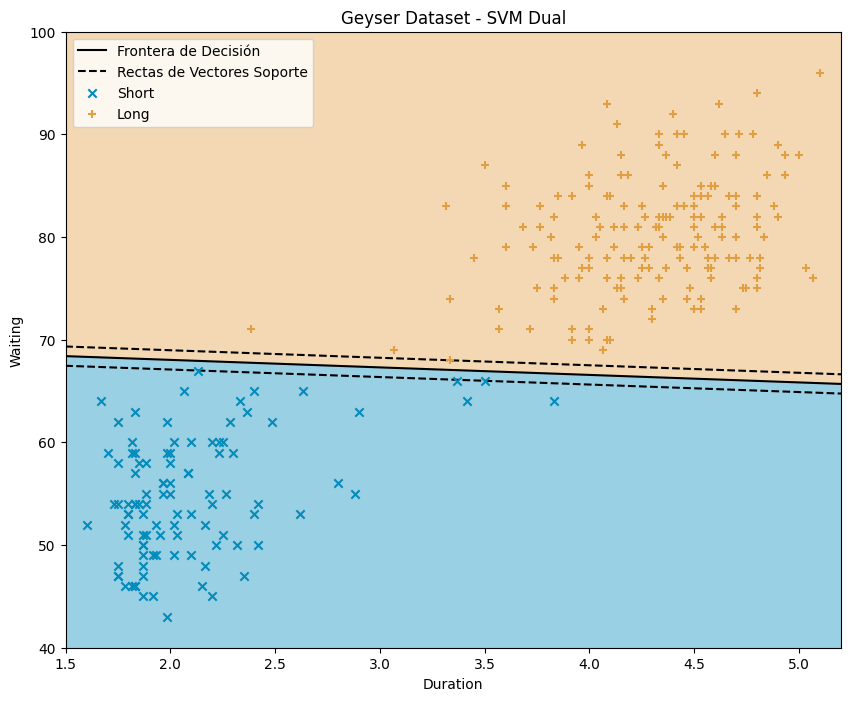

In [13]:
plt.figure(figsize = (10, 8))
plot_boundaries(SVM_Dual, colors)
scatter_dataset(data_short, data_long, 'Geyser Dataset - SVM Dual', colors)
plt.legend(loc = 'upper left')
plt.show()

---

**(D). Repetir el inciso (B) relajando los márgenes (utilizando $C = 0.001$ y $C = 0.1$) y resolviendo el problema primal.**

&ensp; A fin de contemplar errores de clasificación, se introducen variables de holgura $\xi_i \geq 0$, que permiten que ciertos puntos se ubiquen dentro del margen o incluso en el lado incorrecto del hiperplano, penalizando estas desviaciones en la función objetivo con un factor $C$.

&ensp; Esto ayuda a que el modelo no se obsesione con separar perfectamente los datos, especialmente si hay ruido o datos atípicos, y así se evita que termine sobreajustándose para nuevas muestras.

&ensp; Así, a partir de lo visto en el problema primal, se formula el problema primal con márgenes relajados, tal que:

$$\min_{w, ~ b, ~ \xi_i} \frac{1}{2} ||w||^2 + C \sum_{i = 1}^{n} \xi_i ~~~~~~~ \text{s.t.} ~~~~~~~ y_i \left( w^T x_i + b \right) \geq 1 - \xi_i, ~~ \forall 1  \leq i \leq n ~~~  \text{\&} ~~~ \xi_i \geq 0.$$

Donde $C$ es un parámetro que controla cuánto se penalizan los errores: un $C$ grande obliga a respetar el margen más estrictamente, mientras que uno chico permite más flexibilidad. Además, la restricción $y_i \left( w^T x_i + b \right) \geq 1 - \xi_i$ asegura que los puntos se clasifiquen correctamente con una cierta tolerancia, definida por $\xi_i$.

&ensp; Entonces, se debe reformular el problema primal con márgenes suavizados en una expresión del tipo:

$$\min_{z} \frac{1}{2} z^t P z + q^t z ~~~~~~~ \text{s.t.} ~~~~~~~ Gz \leq h, ~~~ Az = b, ~~~ lb \leq z \leq ub;$$

dado que se utiliza la función $\texttt{solve\_qp}$, que recibe parámetros que se correspondan con esta forma. Por ende, se considera:

$$z = \begin{bmatrix} w_1 \\ w_2 \\ b \\ \xi_1 \\ \vdots \\ \xi_n \end{bmatrix} \in \mathbb{R}^{(n+3) \times 1}, ~
P = \begin{bmatrix} 1 & 0 & 0 & \dots & 0 \\ 0 & 1 & 0 & \dots & 0 \\ 0 & 0 & 0 &  \dots & 0 \\ \vdots & \vdots & \vdots & \vdots & \vdots \\ 0 & 0 & 0 & \dots & 0 \end{bmatrix} \in \mathbb{R}^{(n+3) \times (n+3)}, ~
q = \begin{bmatrix} 0 \\ 0 \\ 0 \\ C \\ \vdots \\ C \end{bmatrix} \in \mathbb{R}^{(n+3) \times 1}.$$

&ensp; Así, se tiene que:

\begin{align*}
  \min_{z} \frac{1}{2} z^t P z + q^t z &= \min_{w, ~ b, ~ \xi_i} \frac{1}{2} \begin{bmatrix} w_1 & w_2 & b & \xi_1 & \dots & \xi_n \end{bmatrix}
  \begin{bmatrix} 1 & 0 & 0 & \dots & 0 \\ 0 & 1 & 0 & \dots & 0 \\ 0 & 0 & 0 &  \dots & 0 \\ \vdots & \vdots & \vdots & \vdots & \vdots \\ 0 & 0 &  & \dots & 0 \end{bmatrix}
  \begin{bmatrix} w_1 \\ w_2 \\ b \\ \xi_1 \\ \vdots \\ \xi_n \end{bmatrix} + \begin{bmatrix} 0 & 0 & 0 & C & \dots & C \end{bmatrix} \begin{bmatrix} w_1 \\ w_2 \\ b \\ \xi_1 \\ \vdots \\ \xi_n \end{bmatrix} \\
  &= \min_{w, ~ b} \frac{1}{2} \left( w_1^2 + w_2^2 \right) + C \sum_{i = 1}^n \xi_i  \\
  &= \min_{w, ~ b} \frac{1}{2} ||w||^2 + C \sum_{i = 1}^n \xi_i .
\end{align*}

&ensp; Por otro lado, se definen las matrices de restricciones del problema primal de la siguiente manera:

$$G = -\begin{bmatrix} y_1 X_{1, 1} & y_1 X_{1, 2} & y_1 & 1 & 0 & \dots & 0\\ y_2 X_{2, 1} & y_2 X_{2, 2} & y_2 & 0 & 1 & \dots & 0\\ \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
y_n X_{n, 1} & y_n X_{n, 2} & y_n & 0 & 0 & \dots & 1 \\ 0 & 0 & 0 & 1 & 0 & \dots & 0 \\ 0 & 0 & 0 & 0 & 1 & \dots & 0 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & 0 & 0 & \dots & 1 \end{bmatrix} \in \mathbb{R}^{2n \times (n+3)}, ~
h = - \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \\ 0 \\ \vdots \\ 0\end{bmatrix} \in \mathbb{R}^{2n \times 1};$$

que verifican simultaneamente:

\begin{align*}
  Gz \leq h &\iff -\begin{bmatrix} y_1 X_{1, 1} & y_1 X_{1, 2} & y_1 & 1 & 0 & \dots & 0\\ y_2 X_{2, 1} & y_2 X_{2, 2} & y_2 & 0 & 1 & \dots & 0\\ \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
  y_n X_{n, 1} & y_n X_{n, 2} & y_n & 0 & 0 & \dots & 1 \\ 0 & 0 & 0 & 1 & 0 & \dots & 0 \\ 0 & 0 & 0 & 0 & 1 & \dots & 0 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & 0 & 0 & \dots & 1 \end{bmatrix} \begin{bmatrix} w_1 \\ w_2 \\ b \\ \xi_1 \\ \vdots \\ \xi_n \end{bmatrix} \leq - \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \\ 0 \\ \vdots \\ 0\end{bmatrix} \\
  &\iff \begin{bmatrix} -y_1 X_{1, 1} \cdot w_1 - y_2 X_{1, 2} \cdot w_2 - y_1 \cdot b - \xi_1 \\ -y_1 X_{2, 1} \cdot w_1 - y_2 X_{2, 2} \cdot w_2 - y_2 \cdot b - \xi_2\\
  \vdots \\ -y_n X_{n, 1} \cdot w_1 - y_n X_{n, 2} \cdot w_2 - y_n \cdot b - \xi_n \\ -\xi_1 \\ \vdots \\ -\xi_n \end{bmatrix} \leq -  \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \\ 0 \\ \vdots \\ 0\end{bmatrix}  \\ \\
  &\iff -y_i \cdot \left( w^T X_i + b \right) - \xi_i \leq -1, ~~ \forall 1 \leq i \leq n \iff y_i \cdot \left( w^T X_i + b \right) \geq 1 - \xi_i, ~~ \forall 1 \leq i \leq n \\
  &\iff -\xi_i \leq 0 \iff \xi_i \geq 0
\end{align*}

&ensp; De esta manera, se implementa en la clase `svm_primal` el problema primal con los márgenes relajados, reutilizando el algoritmo del *VSM* primal y agregando ciertos términos a las matrices utilizadas en el método `fit`, según corresponda. Para hacer uso de los márgenes relajados, se debe especificar un valor para $C$.

&ensp; Luego, se inicializan y se entrenan las clases con los valores de $C$ dados por la cátedra y se grafican las fronteras de decisión y las rectas de vectores soporte de cada uno de los casos.


In [14]:
SVM_Primal_M1 = svm_primal(C = 0.1)
SVM_Primal_M1.fit(X_data, Y_data)

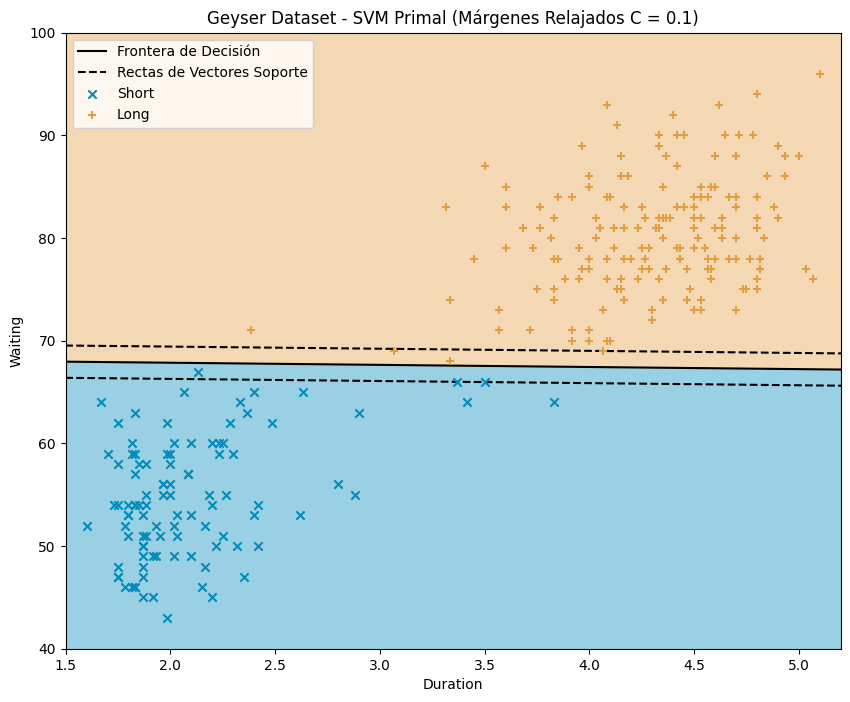

In [15]:
plt.figure(figsize = (10, 8))

plot_boundaries(SVM_Primal_M1, colors)
scatter_dataset(data_short, data_long, 'Geyser Dataset - SVM Primal (Márgenes Relajados C = 0.1)', colors)

plt.legend(loc = 'upper left')
plt.show()

In [16]:
SVM_Primal_M2 = svm_primal(C = 0.001)
SVM_Primal_M2.fit(X_data, Y_data)

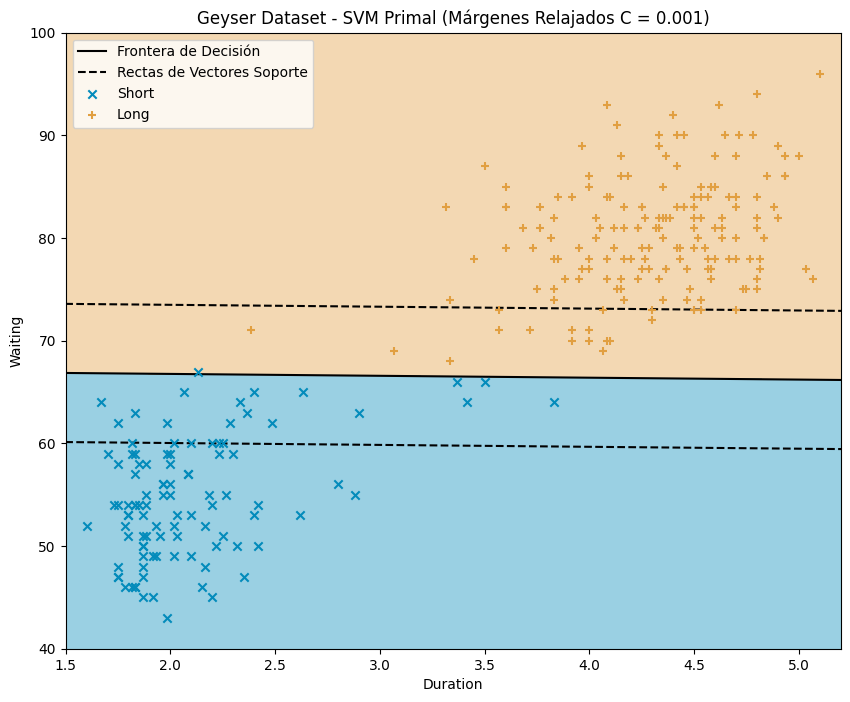

In [17]:
plt.figure(figsize = (10, 8))
plot_boundaries(SVM_Primal_M2, colors)
scatter_dataset(data_short, data_long, 'Geyser Dataset - SVM Primal (Márgenes Relajados C = 0.001)', colors)
plt.legend(loc = 'upper left')
plt.show()

---

**(E). Hallar el problema dual con márgenes relajados. Efectuar el desarrollo matemático de la misma.**

&ensp; A fin de hallar el problema primal con márgenes relajados (visto en el ejercicio **(D)**), se debe escribir en función de sus multiplicadores de Lagrange ($\alpha_i$):

$$\min_{w, ~ b, ~ \xi_i} \max_{\alpha_i, ~ \beta_i \geq 0} \frac{1}{2} ||w||^2 + C \sum_{i = 1}^n \xi_i - \sum_{i = 1}^n \alpha_i \cdot \left[ y_i (w^T x_i + b) - (1 - \xi_i) \right] - \sum_{i=1}^n \beta_i \cdot \xi_i.$$

&ensp; Al igual que para el problema dual, se puede invertir el máximo y el mínimo, dado que, *SVM* es un problema convexo. Entonces:

$$\max_{\alpha_i, ~ \beta_i \geq 0} \min_{w, ~ b, ~ \xi_i}  \frac{1}{2} ||w||^2 + C \sum_{i = 1}^n \xi_i - \sum_{i = 1}^n \alpha_i \cdot \left[ y_i (w^T x_i + b) - (1 - \xi_i) \right] - \sum_{i=1}^n \beta_i \cdot \xi_i.$$

&ensp; Así, se define $f(w, ~ b, ~\xi_i, ~ \alpha, ~\beta)$ como la función a optimizar:

\begin{align*}
f(w, ~ b, ~\xi_i, ~ \alpha, ~\beta) &= \frac{1}{2} ||w||^2 + C \sum_{i = 1}^n \xi_i - \sum_{i = 1}^n \alpha_i \cdot \left[ y_i (w^T x_i + b) - (1 - \xi_i) \right] - \sum_{i=1}^n \beta_i \cdot \xi_i \\
&=  \frac{1}{2} ||w||^2 + C \sum_{i = 1}^n \xi_i - w^T \sum_{i = 1}^n \alpha_i y_i x_i - b \sum_{i = 1}^n \alpha_i y_i + \sum_{i=1}^n \alpha_i - \sum_{i=1}^n \left( \alpha_i + \beta_i \right) \xi_i.
\end{align*}

Derivando esto en función de $w$, $b$ y $\xi_i$ e igualando a cero, se puede reescribir la función, tal que:

\begin{align*}
\begin{cases}
\frac{\partial}{\partial w} f(w, ~ b, ~\xi_i, ~ \alpha, ~\beta) = w - \sum_{i = 1}^n \alpha_i y_i x_i = 0 \Rightarrow w = \sum_{i = 1}^n \alpha_i y_i x_i \\
\frac{\partial}{\partial b} f(w, ~ b, ~\xi_i, ~ \alpha, ~\beta) = -\sum_{i = 1}^n \alpha_i y_i = 0 \\
\frac{\partial}{\partial \xi_i} f(w, ~ b, ~\xi_i, ~ \alpha, ~\beta) =  C - \alpha_i - \beta_i = 0 \Rightarrow C = \alpha_i + \beta_i
\end{cases}
\end{align*}

\begin{align*}
\Longrightarrow f(w, ~ b, ~\xi_i, ~ \alpha, ~\beta) &= \frac{1}{2} ||w||^2 + C \sum_{i = 1}^n \xi_i - w^T \underbrace{\sum_{i = 1}^n \alpha_i y_i x_i}_w - \underbrace{b \sum_{i = 1}^n \alpha_i y_i}_{=~0} + \sum_{i=1}^n \alpha_i - \sum_{i=1}^n \underbrace{\left( \alpha_i + \beta_i \right)}_C \xi_i \\
&= \frac{1}{2} ||w||^2 + C \sum_{i = 1}^n \xi_i - ||w||^2 + \sum_{i=1}^n \alpha_i - C \sum_{i = 1}^n \xi_i\\
&= -\frac{1}{2} ||w||^2 + \sum_{i=1}^n \alpha_i.
\end{align*}

Este resultado es el mismo que en el caso primal sin márgenes relajados, lo cual sugiere que se debe maximizar la siguiente expresión.

$$\max_{\alpha} -\frac{1}{2} \alpha^T P \alpha + \alpha^T 1 ~~~~~~~ \text{s.t.} ~~~~~~~ \alpha^T y = 0, ~ \alpha_i \geq 0.$$

Sin embargo, observando las restricciones dadas por las derivadas, además se debe cumplir que:

$$C = \alpha_i + \beta_i ~~~~ \text{con} ~~~ \beta, ~ \alpha \geq 0;$$

pero la función a maximizar no depende de $\beta$, por lo tanto, se puede deducir el rango de valores de $\alpha$, de forma tal que la expresión a maximizar considerando los márgenes relajados es:

$$\max_{\alpha} -\frac{1}{2} \alpha^T P \alpha + \alpha^T 1 ~~~~~~~ \text{s.t.} ~~~~~~~ \alpha^T y = 0, ~ 0 \leq \alpha_i \leq C.$$

&ensp; De esta manera, para reformular el problema dual con márgenes suavizados en una expresión de la forma:

$$\min_{z} \frac{1}{2} z^t P z + q^t z ~~~~~~~ \text{s.t.} ~~~~~~~ Gz \leq h, ~~~ Az = b, ~~~ lb \leq z \leq ub;$$

se utilizan las mismas matrices $P$, $q$, $A$ y $b$ que para el problema dual y, en lugar de utilizar la restricción $Gz \leq h$ con $G$ y $h$, se utiliza $lb \leq z \leq ub$ con las siguientes matrices:

\begin{align*}
  lb = \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix} \in \mathbb{R}^n, ~
  ub = \begin{bmatrix} C \\ C \\ \vdots \\ C \end{bmatrix} \in \mathbb{R}^n
\end{align*}

&ensp; Todo esto se implementa en la clase `svm_dual`, que considera que en el caso de que se le pase un $C$ como parámetro se construyen las matrices $lb$ y $ub$ para resolver el problema dual con márgenes relajados.


---

**(F) Repetir el inciso (B) relajando los márgenes (utilizando $C = 0.001$ y $C = 0.1$) y resolviendo el problema dual.**

&ensp; A partir de la implementación del problema dual con los márgenes relajados en el código, se inicializa y se entrenan diferentes clases con los distintos valores de $C$ propuestos por la cátedra. Así, se grafican las fronteras de decisión y las rectas de vectores soporte.

In [18]:
SVM_Dual_M1 = svm_dual(C = 0.1)
SVM_Dual_M1.fit(X_data, Y_data)

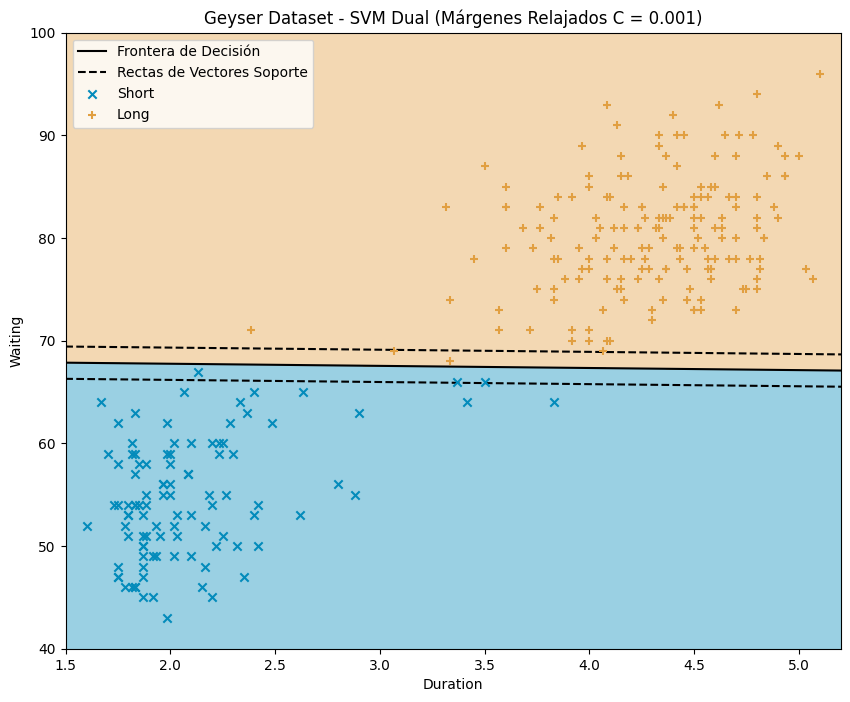

In [19]:
plt.figure(figsize = (10, 8))
plot_boundaries(SVM_Dual_M1, colors)
scatter_dataset(data_short, data_long, 'Geyser Dataset - SVM Dual (Márgenes Relajados C = 0.001)', colors)
plt.legend(loc = 'upper left')
plt.show()

In [20]:
SVM_Dual_M2 = svm_dual(C = 0.001)
SVM_Dual_M2.fit(X_data, Y_data)

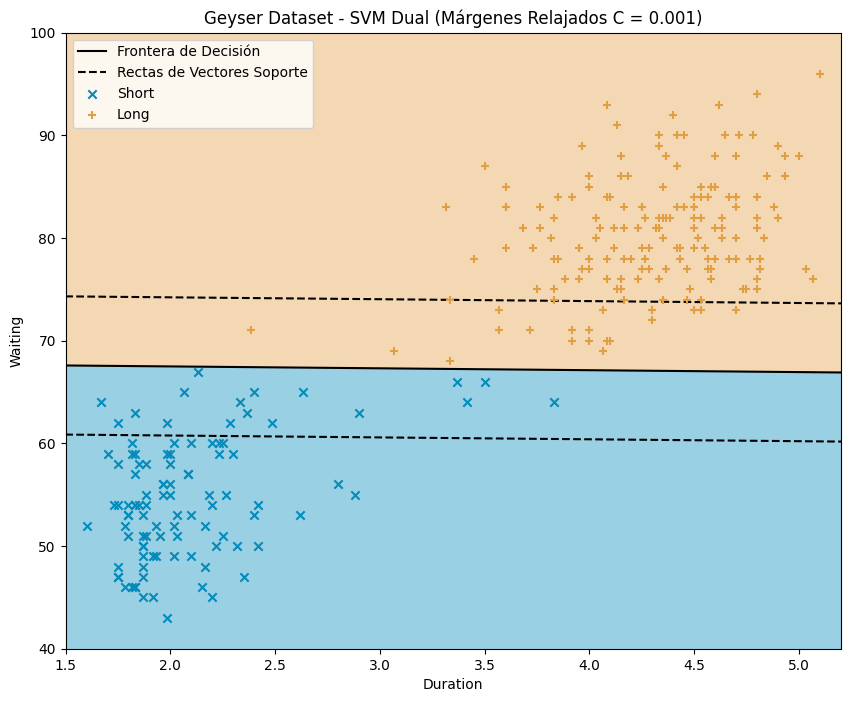

In [21]:
plt.figure(figsize = (10, 8))
plot_boundaries(SVM_Dual_M2, colors)
scatter_dataset(data_short, data_long, 'Geyser Dataset - SVM Dual (Márgenes Relajados C = 0.001)', colors)
plt.legend(loc = 'upper left')
plt.show()

---

**(G) Utilizando $\texttt{subplot}$ (`pyplot`) mostrar los 6 gráficos en una misma figura. Extraer conclusiones.**

&ensp; Considerando las figuras que se observan a lo largo del trabajo, se utilizan las funciones $\texttt{plot\_boundaries}$ y $\texttt{scatter\_dataset}$ para graficar las fronteras de decisión, las rectas de vectores soporte y las muestras en una misma figura. Esto se realiza con el fin de analizar los resultados obtenidos.

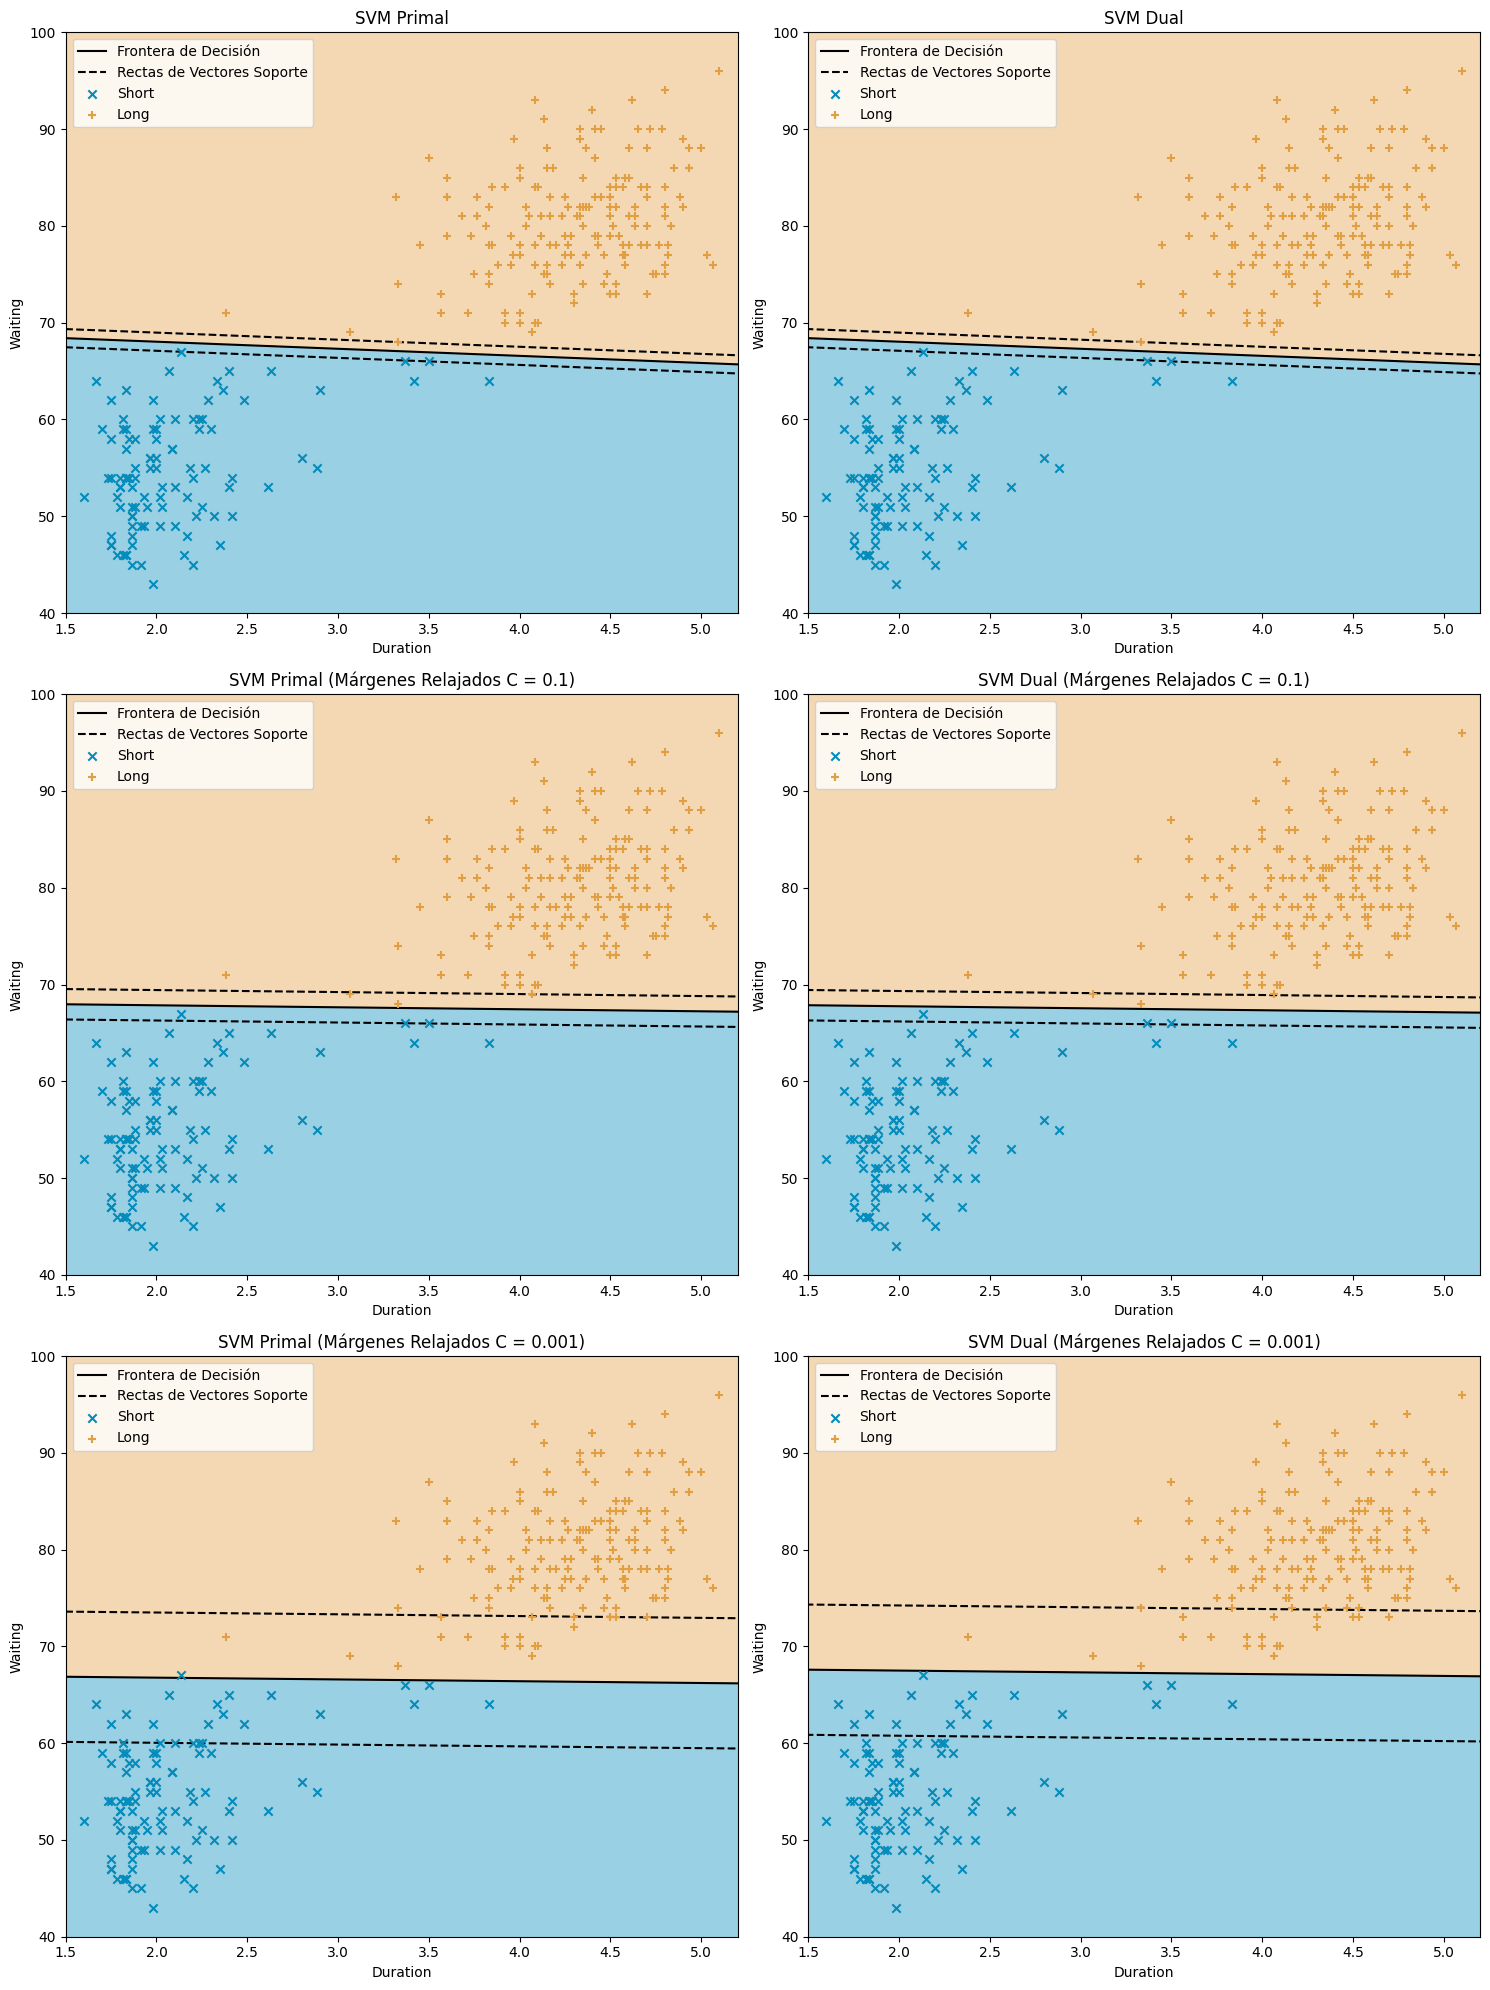

In [22]:
plt.figure(figsize = (15, 20))
plt.subplot(3, 2, 1)
plot_boundaries(SVM_Primal, colors)
scatter_dataset(data_short, data_long, 'SVM Primal', colors)
plt.legend(loc = 'upper left')

plt.subplot(3, 2, 2)
plot_boundaries(SVM_Dual, colors)
scatter_dataset(data_short, data_long, 'SVM Dual', colors)
plt.legend(loc = 'upper left')

plt.subplot(3, 2, 3)
plot_boundaries(SVM_Primal_M1, colors)
scatter_dataset(data_short, data_long, 'SVM Primal (Márgenes Relajados C = 0.1)', colors)
plt.legend(loc = 'upper left')

plt.subplot(3, 2, 4)
plot_boundaries(SVM_Dual_M1, colors)
scatter_dataset(data_short, data_long, 'SVM Dual (Márgenes Relajados C = 0.1)', colors)
plt.legend(loc = 'upper left')

plt.subplot(3, 2, 5)
plot_boundaries(SVM_Primal_M2, colors)
scatter_dataset(data_short, data_long, 'SVM Primal (Márgenes Relajados C = 0.001)', colors)
plt.legend(loc = 'upper left')

plt.subplot(3, 2, 6)
plot_boundaries(SVM_Dual_M2, colors)
scatter_dataset(data_short, data_long, 'SVM Dual (Márgenes Relajados C = 0.001)', colors)
plt.legend(loc = 'upper left')

plt.tight_layout()
plt.show()

&ensp; De este modo, se observa que las imágenes obtenidas al resolver el problema primal y el problema dual son iguales. Esto se debe a que, aunque utilizan métodos distintos: el primal directamente sobre las variables originales y el dual mediante los multiplicadores de Lagrange; ambos enfoques resuelven el mismo problema de optimización. En consecuencia, la frontera de decisión obtenida es la misma, ya que ambos métodos encuentran el mismo hiperplano óptimo que separa las clases y las rectas de vectores soporte se condicen entre sí.

&ensp; Además, se analizan las diferencias entre los esquemas obtenidos a partir de que se relajaron los márgenes. En el caso sin márgenes relajados (*hard margin*), no se permite que ninguna muestra quede del lado incorrecto del hiperplano, por lo tanto, se toman como vectores soportes a los más cercanos a la frontera de decisión, como se ve en las figuras. En este caso, las muestras deben ser perfectamente separables, lo que puede ser difícil de lograr si los datos no son linealmente separables. Por el contrario, el enfoque de *soft margin* introduce una tolerancia a errores, permitiendo que algunas muestras queden dentro del margen a través de las variables de holgura $\xi_i$ y el valor de sus pesos $C$ (a menor $C$ mayor relajación, como se ve en las figuras). Así, este modelo puede generalizar mejor en presencia de datos no perfectamente separables, dejando pasar más muestras cerca o dentro del margen y mejorando el *overfitting*.

---
---

<div style="text-align: center;">
  <h3> Conclusiones
</div>

&ensp; En el presente trabajo práctico se implementó un clasificador *SVM* desde cero, trabajando desde la formulación teórica hasta su aplicación práctica sobre un conjunto de datos reales. El proceso permitió entender mejor cómo se construye el problema de optimización y cómo se realiza el algoritmo en un un lenguaje como $\texttt{Python}$

&ensp; Se desarrollaron de forma teórica las expresiones necesarias para plantear tanto el problema primal de maximización del margen como su correspondiente formulación dual. Además, se estudió la relajación de márgenes en ambos enfoques, considerando la inclusión de términos que penalizan errores de clasificación.

&ensp; Un aspecto central fue la construcción de las matrices y vectores requeridos por la función $\texttt{solve\_qp}$, debiendo adaptar las expresiones trabajadas en las clases teóricas a la forma cuadrática exigida por la misma. También fue necesario ajustar las restricciones del problema a la notación específica que maneja dicha función.

&ensp; Por otro lado, el análisis gráfico mostró de manera clara cómo el modelo logra separar efectivamente las dos clases presentes en el dataset trabajado. También se observaron las diferencias geométricas que surgen al aplicar o no la relajación de los márgenes, evidenciando el impacto que tienen en la posición del hiperplano y en la clasificación de los datos.

&ensp; En resumen, el trabajo permitió reforzar los conceptos vistos en las clases teóricas, además de adquirir experiencia práctica programando un *SVM* y visualizando cómo se comporta frente a datos reales.